# Ramón Denia Test - Modelling

With given dataset, predict the probability of the payment within 90 days!

Data is stored as a small SQLite database stored in attached `dataset.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

In [3]:
con = sqlite3.connect('dataset.db')

df_meta = pd.read_sql_query('SELECT * FROM metadata;', con)
df_meta

,varcode,name,var_class,entity_table
0,a8404,RatioOfCustomersAtAddressWithSuccessfullyClose...,variable,address
1,ap090,TargetAmount90Days,target,case
2,c0001,OriginalCapitalOfCaseInvoices,variable,case
3,c0015,AmountOfCase,variable,case
4,c0019,AgeOfDebt,variable,case
5,c0031,NumberOfTelephonesCI,variable,case
6,c0039,IndustryCode,variable,case
7,c0044,ClientName,variable,case
8,c9008,CustomerAge,variable,case
9,ct090,Target90Days,target,case


In [4]:
df_meta["name"].values

array(['RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months',
       'TargetAmount90Days', 'OriginalCapitalOfCaseInvoices',
       'AmountOfCase', 'AgeOfDebt', 'NumberOfTelephonesCI',
       'IndustryCode', 'ClientName', 'CustomerAge', 'Target90Days',
       'AmountOfCustomerPaymentsOnAllCasesBlevel',
       'AmountOfCustomerOpenCases', 'LastOriginalClosingCodeOfCustomer',
       'NumberOfCustomerIncomingCallDatesTee',
       'NumberOfSuccessfullyClosedCasesInLast24Months',
       'NumberOfCustomerPaymentsInLast12Months',
       'NumberOfUnsuccessfullyClosedCustomerCasesLast36Months'],
      dtype=object)

In [5]:
df_data = pd.read_sql_query('SELECT * FROM dataset;', con)
df_data.head()

,case_id,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
0,1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
1,2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
2,3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.0,748.0,0.0,48.0,NaN,3,NaN,56.84
3,4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.0,8.0,0.0,27.0,NaN,4,NaN,463.15
4,5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09


### Some background information on the data

The intended target for prediction is `ct090`, `case_id` is the unique identifier, `keydate` is the point in time when some event has happened in the lifecycle of a case, and also a date relative to which all of the backward looking variables and forward looking targets are calculated. In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified. In other words, `keydate` is set a few days after registration, and target `ct090` is checking for outcome in 90 days (`ap090` is a similar regression target), while all the rest of the data is only looking backwards!

Metadata gives some basic description of variables. The general naming convention is based on prefixes that define aggregation levels - `cXXXX` looking at the data of this case only, `dXXXX` looking at other cases of same debtor, `bXXXX` looking at all cases of the debtor, `aXXXX` looking at all the cases on the same address. Note that this data selection has quite a few variables with the `dXXXX` prefix, which means that this selection is specifically looking at debtors that we already had worked with before, therefore, variable selection is much broader and models are generally better. 

One more tip on interpretation of missing values: if variable is bound by time window, e.g. `d2112 NumberOfCustomerPaymentsInLast12Months`, the `NA` value implies that there never have been any values, while `0` would mean that have been no values within bounding period (in this case 12 months). In other words, `0` and `NA` have different interpretation. It may or may not be relevant, depending on the choice of the modelling approach. 

# DATA ANALYSIS

In [6]:
df_data.shape

(30000, 19)

In [7]:
df_data.describe()

,case_id,ct090,ap090,c0001,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
count,30000.000000,30000.000000,30000.000000,29975.000000,17371.000000,13074.000000,30000.000000,30000.000000,19599.000000,30000.000000,30000.000000,27016.000000,13048.000000,8762.000000,30000.000000
mean,15000.500000,0.168733,49.215836,538.590694,1.634391,423.156043,555.063823,3.092900,0.283395,104.948833,0.473067,42.339466,0.935622,0.897170,605.535361
std,8660.398374,0.374522,240.063401,1248.533877,1.318419,902.166491,1939.588574,2.151021,0.312366,196.864753,1.397094,13.215883,1.755761,0.814515,1223.783876
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-319.010000,0.000000,0.000000,3.000000,0.000000,6.000000,0.000000,0.000000,9.750000
25%,7500.750000,0.000000,0.000000,145.100000,1.000000,76.000000,0.000000,2.000000,0.000000,10.000000,0.000000,32.000000,0.000000,0.000000,185.410000
50%,15000.500000,0.000000,0.000000,298.720000,1.000000,202.715000,0.000000,3.000000,0.210000,77.000000,0.000000,41.000000,0.000000,1.000000,355.650000
75%,22500.250000,0.000000,0.000000,638.645000,2.000000,500.677500,481.322500,4.000000,0.450000,126.000000,0.000000,51.000000,1.000000,1.000000,725.480000
max,30000.000000,1.000000,25000.000000,84561.840000,15.000000,53982.610000,110158.640000,35.000000,1.000000,6193.000000,40.000000,117.000000,24.000000,15.000000,84561.840000


In [8]:
df_data = df_data.set_index('case_id', drop=True)

In [9]:
df_data.head()

,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
case_id,,,,,,,,,,,,,,,,,,
1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.0,748.0,0.0,48.0,NaN,3,NaN,56.84
4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.0,8.0,0.0,27.0,NaN,4,NaN,463.15
5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09


We want to have a quick overview of the dataset, checking the values and the nulls for each feature.

We can realize that all the variables of our dataset are numerical, and this first detail it's very important before starting our analysis and preparing or route plan. We have some of our numerical features that represent categorical values (like **c0039** and **c0044**). So we must pay attention to those features and don't treat them as integers.

In [10]:
for i in df_data.columns:
    print('***********************************')
    print('Name of the feature: %s' %i)
    print('Length of each feature regarding the unique values')
    print(len(df_data[i].unique()))
    print(df_data[i].value_counts())   

***********************************
Name of the feature: keydate
Length of each feature regarding the unique values
189
2017-02-23 00:00:00.0    1184
2017-09-18 00:00:00.0    1007
2017-08-20 00:00:00.0     995
2017-06-22 00:00:00.0     978
2017-07-21 00:00:00.0     854
                         ... 
2017-09-23 00:00:00.0       8
2017-08-13 00:00:00.0       7
2017-01-15 00:00:00.0       7
2017-01-06 00:00:00.0       4
2017-08-06 00:00:00.0       4
Name: keydate, Length: 189, dtype: int64
***********************************
Name of the feature: ct090
Length of each feature regarding the unique values
2
0.0    24938
1.0     5062
Name: ct090, dtype: int64
***********************************
Name of the feature: ap090
Length of each feature regarding the unique values
4152
0.00       24950
100.00       140
50.00        106
150.00        54
30.00         43
           ...  
250.76         1
1269.35        1
141.64         1
382.74         1
55.06          1
Name: ap090, Length: 4152, dtype: i

In [11]:
# Nº of nulls per feature
no_nulls=df_data.isnull().sum()
no_nulls

keydate        0
ct090          0
ap090          0
c0001         25
c0039          0
c0044          0
d0031      12629
b0007      16926
d0009          0
c0031          0
a8404      10401
c0019          0
d0027          0
c9008       2984
d2112      16952
d0012          0
d1205      21238
c0015          0
dtype: int64

In [12]:
# % of nulls per feature
per_nulls=df_data.isnull().sum()/len(df_data)*100
per_nulls

keydate     0.000000
ct090       0.000000
ap090       0.000000
c0001       0.083333
c0039       0.000000
c0044       0.000000
d0031      42.096667
b0007      56.420000
d0009       0.000000
c0031       0.000000
a8404      34.670000
c0019       0.000000
d0027       0.000000
c9008       9.946667
d2112      56.506667
d0012       0.000000
d1205      70.793333
c0015       0.000000
dtype: float64

# Missing not at Random 

After dealing with all null values, we want to check if there is a pattern within the dataset. There is a method called: Missing Not at Random where we can detect if exist a pattern inside these null values. 

Let's first define Missing Not at Random (MNAR): There is a relationship between the propensity of a value to be missing and its values. In other words, data are missing not at random when the missing values of a variable are related to the values of that variable itself, even after controlling for other variables. 

An example would be a survey with regard to drug usage. Individuals being surveyed could potentially leave fields blank if they used drugs that are currently illegal out of fear of being prosecuted. So the fields aren't blank out of randomness but are left null on purpose.

And in our case study, we have some similar situations with the Number of cases that occur at some period of time. NaN means in that particular situation that our client hasn't had a value in his historical data. 

In [13]:
# You need to install the following library in order to run the MNAR section
# !pip install missingno

In [14]:
import missingno as msno

The final and most difficult situation of missingness. MNAR occurs when the missingness is not random, and there is a systematic relationship between missing value, observed value, and missing itself. To make sure, If the missingness is in 2 or more variables holding the same pattern, you can sort the data with one variable and visualize it

<AxesSubplot:>

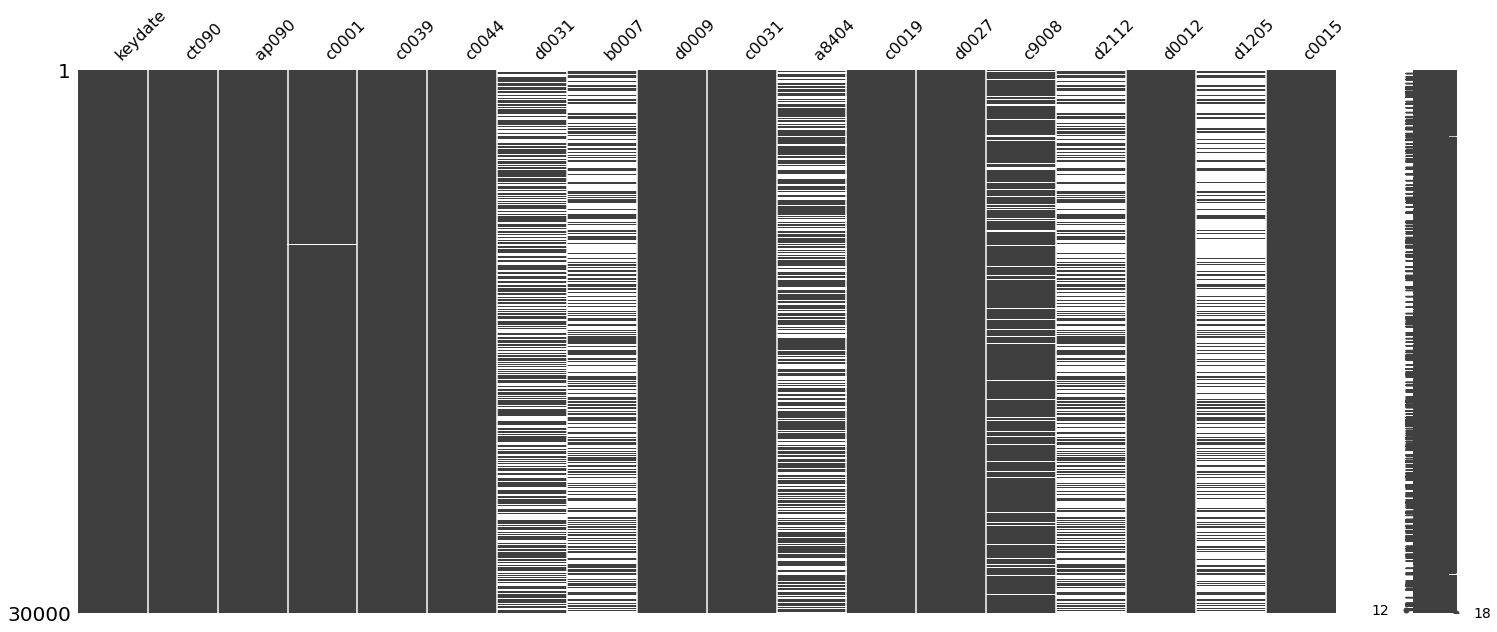

In [15]:
msno.matrix(df_data)

<AxesSubplot:>

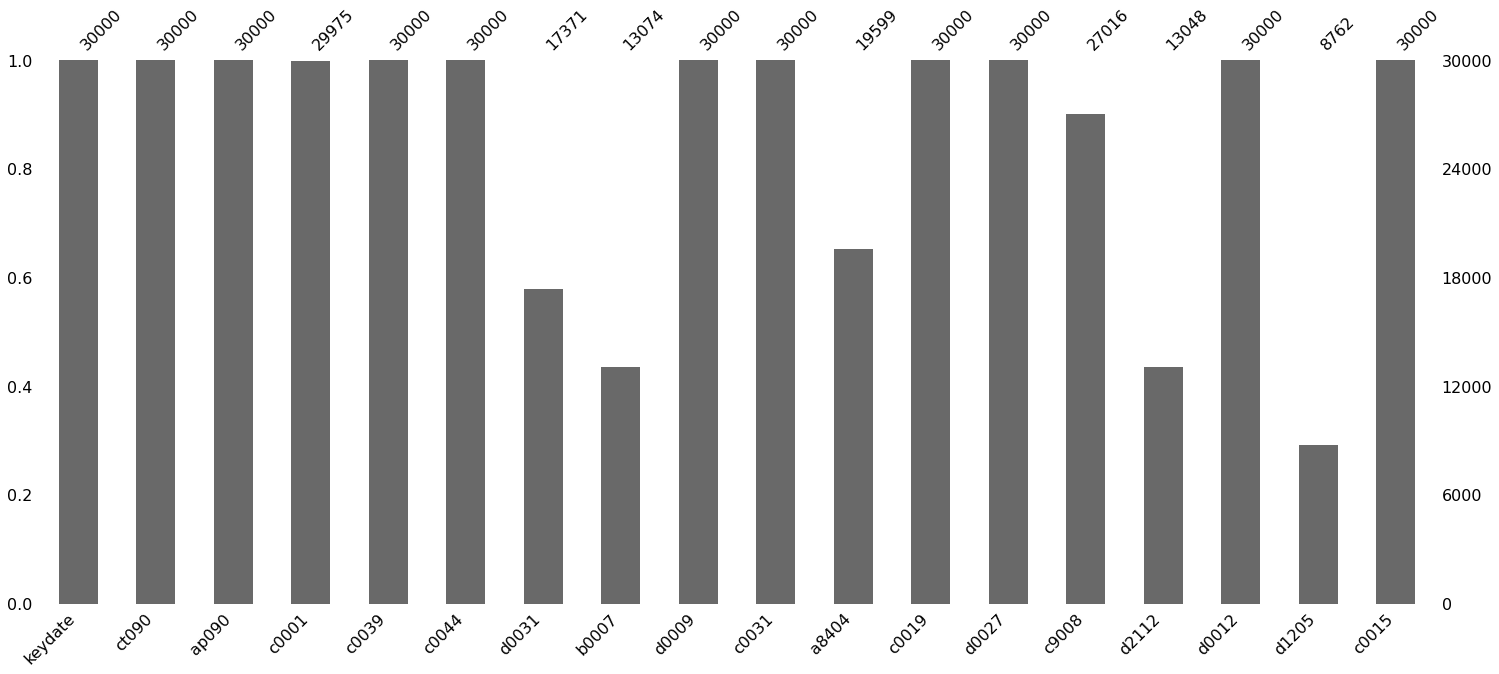

In [16]:
msno.bar(df_data)

<AxesSubplot:>

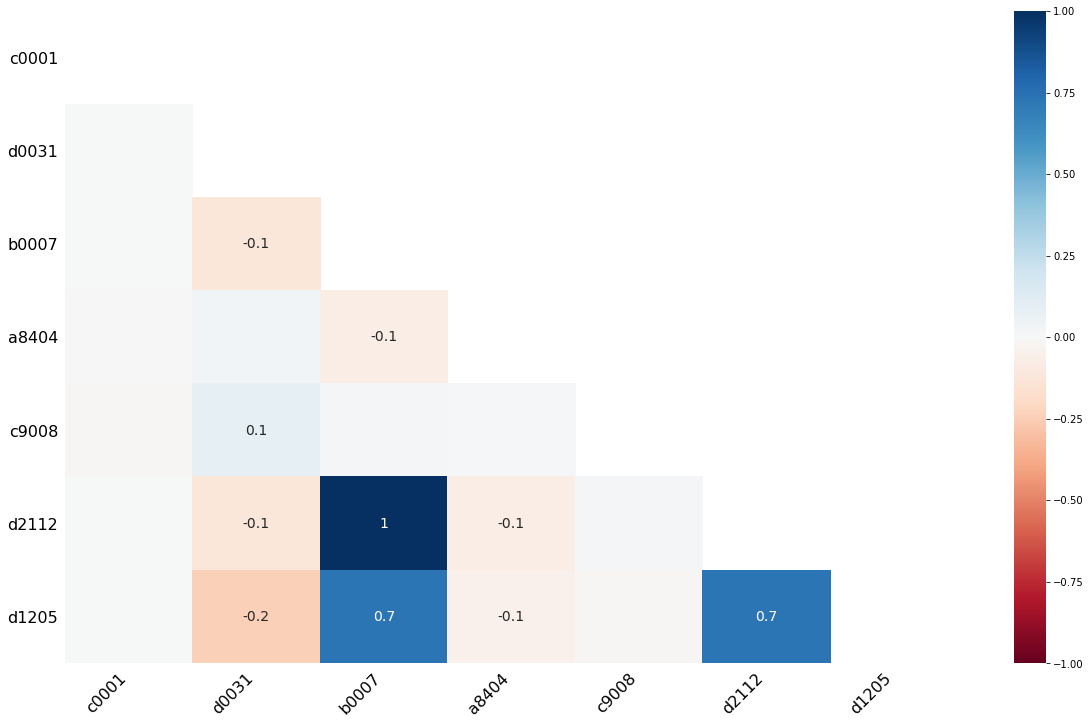

In [17]:
msno.heatmap(df_data)

<AxesSubplot:>

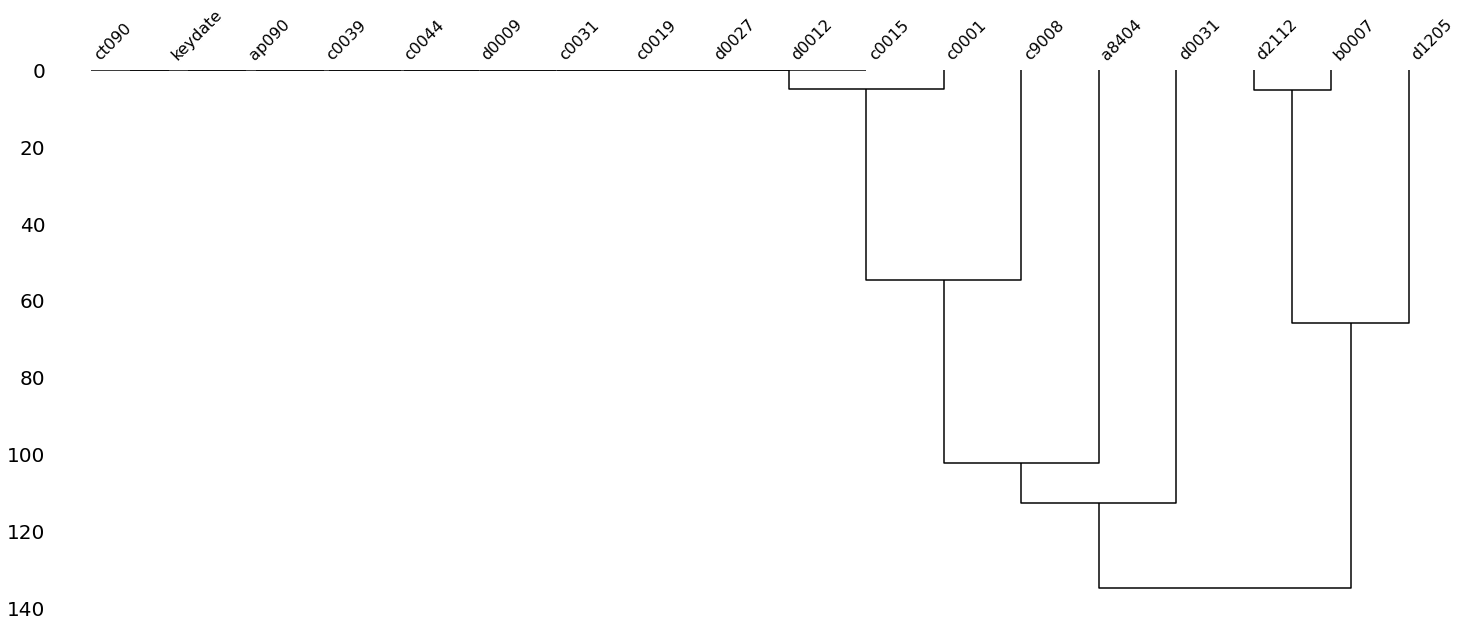

In [18]:
msno.dendrogram(df_data)

We can clearly see in both sketches (dendogram and confusion matrix) that there is a 100% correlation between ***d2112*** and ***b007***. So let's analyze the dataset separating the nulls from those features to check the pattern.

In [19]:
# Let's separate the nulls into another dataset taking the nulls from the feature d2112 (56.506667% of null values)

missing_data = df_data[df_data["d2112"].isnull()]
missing_data.head()

,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
case_id,,,,,,,,,,,,,,,,,,
3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.00,748.0,0.0,48.0,NaN,3,NaN,56.84
4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.00,8.0,0.0,27.0,NaN,4,NaN,463.15
6,2017-05-13 00:00:00.0,0.0,0.0,56.77,K6512,6,1.0,NaN,0.00,3.0,NaN,4.0,0.0,47.0,NaN,1,NaN,117.77
7,2017-02-23 00:00:00.0,0.0,0.0,667.65,K6622,7,NaN,NaN,147.09,4.0,NaN,13.0,0.0,35.0,NaN,4,NaN,717.65
8,2017-09-02 00:00:00.0,0.0,0.0,77.20,K6622,8,2.0,NaN,152.56,1.0,0.36,64.0,0.0,47.0,NaN,1,NaN,107.82


<AxesSubplot:>

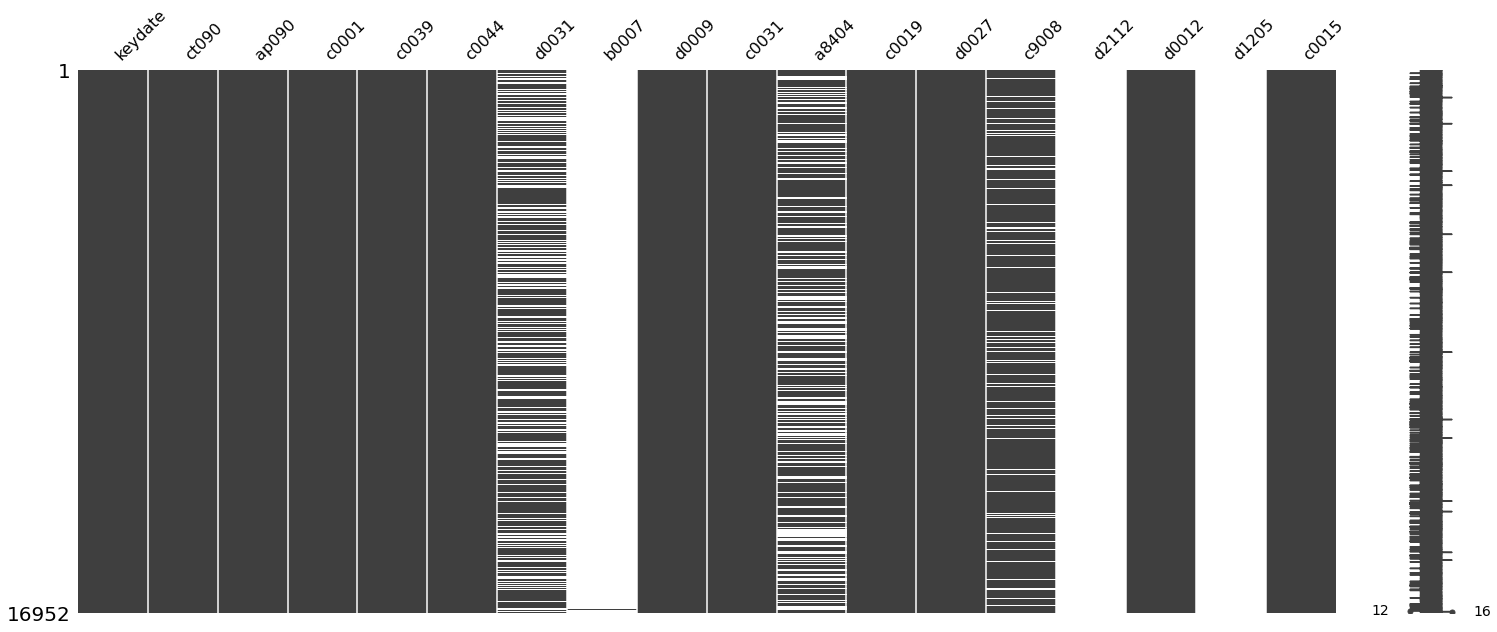

In [20]:
msno.matrix(missing_data)

We can confirm that there is a clear pattern between the feature ***b007***, ***d2112*** and ***d1205***. For future analysis, we are going to separate the nulls values from correct values, to be analyzed through the model and check if the information from those columns increases the precision of our model.

In [21]:
# Let's separate the null pattern columns into one dataset and the other columns (some of the with nulls)

missing_data_pattern = df_data[df_data["d2112"].isnull()]
missing_data_no_pattern = df_data[df_data["d2112"].notnull()]

<AxesSubplot:>

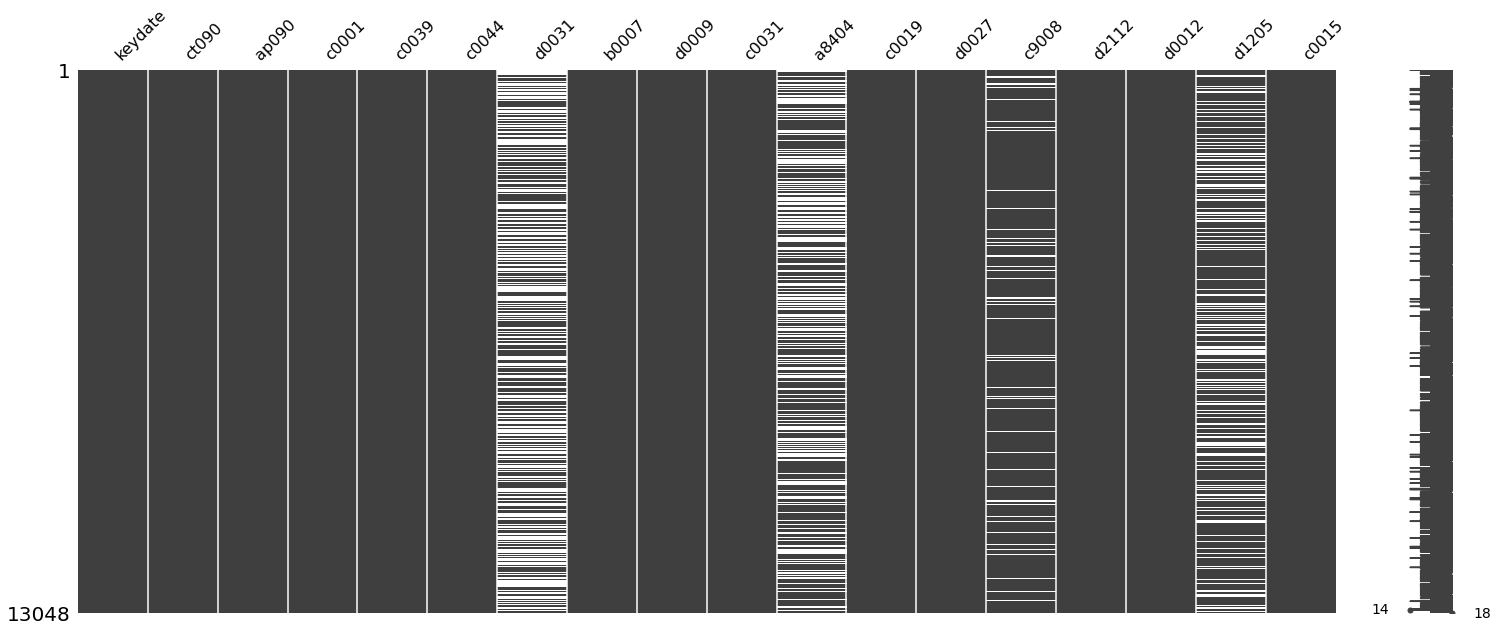

In [22]:
msno.matrix(missing_data_no_pattern)

# Dealing with Nan values

Once we have analyzed that there is a pattern in the missing data, we will replace the missing values depending on the data we have per feature. We see that we have such a big percentage of nulls in some of the features. Our task before we proceed with the analysis is to deal with these null values.

## Original Capital Of Case Invoices --> c0001  

In [23]:
df_data["c0001"].describe()

count    29975.000000
mean       538.590694
std       1248.533877
min          0.000000
25%        145.100000
50%        298.720000
75%        638.645000
max      84561.840000
Name: c0001, dtype: float64

In [24]:
df_data["c0001"].isnull().sum()

25

This feature has a small amount of null values compared with the size of the feature. We could drop this small quantity of null values, but in order to keep as much information as possible, we won't drop them and we will take the mean as a value to fill the NaN values. We take the mean of the feature because we are talking about money. 

In [25]:
df_data["c0001"]=df_data["c0001"].fillna(df_data["c0001"].mean())

In [26]:
df_data["c0001"].isnull().sum()

0

## Number Of Unsuccessfully Closed Customer Cases Last 36 Months --> d0031

In [27]:
df_data["d0031"].describe()

count    17371.000000
mean         1.634391
std          1.318419
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: d0031, dtype: float64

In [28]:
df_data["d0031"].isnull().sum()

12629

In this feature, we have a big quantity of null values (close to the half). So for this feature we have 2 options, fill the values with valid value above/below or we can drop this column for our final analysis. All the NaN values means that those clients never had an unsuccessfully closed case. 

In [29]:
df_data["d0031"]=df_data["d0031"].fillna(method='ffill', inplace=False)

In [30]:
df_data["d0031"].isnull().sum()

0

## Amount Of Customer Payments On All Cases B level	 --> b0007

In [31]:
df_data["b0007"].describe()

count    13074.000000
mean       423.156043
std        902.166491
min          0.000000
25%         76.000000
50%        202.715000
75%        500.677500
max      53982.610000
Name: b0007, dtype: float64

In [32]:
df_data["b0007"].isnull().sum()

16926

For this feature, we have again a huge percentage of missing values. We are talking about amounts not about a number regarding time, so we will take a different approach, we will fill again the values with the mean.

In [33]:
df_data["b0007"]=df_data["b0007"].fillna(df_data["b0007"].mean())

In [34]:
df_data["b0007"].isnull().sum()

0

## Ratio Of Customers At Address With Successfully Closed Cases Last 36 Months --> a8404

In [35]:
df_data["a8404"].describe()

count    19599.000000
mean         0.283395
std          0.312366
min          0.000000
25%          0.000000
50%          0.210000
75%          0.450000
max          1.000000
Name: a8404, dtype: float64

In [36]:
df_data["a8404"].isnull().sum()

10401

In this case, we are going to use the same method we did for the null values regarding time and but this time we will fill the values with the above valid value. 

In [37]:
df_data["a8404"]=df_data["a8404"].fillna(method='backfill', inplace=False)

In [38]:
df_data["a8404"].isnull().sum()

0

## Customer Age --> c9008

In [39]:
df_data["c9008"].describe()

count    27016.000000
mean        42.339466
std         13.215883
min          6.000000
25%         32.000000
50%         41.000000
75%         51.000000
max        117.000000
Name: c9008, dtype: float64

In [40]:
df_data["c9008"].isnull().sum()

2984

In [41]:
df_data["c9008"]=df_data["c9008"].fillna(df_data["c9008"].mean())

In [42]:
df_data["c9008"].isnull().sum()

0

## Number Of Customer Payments In Last 12 Months --> d2112

In [43]:
df_data["d2112"].describe()

count    13048.000000
mean         0.935622
std          1.755761
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         24.000000
Name: d2112, dtype: float64

In [44]:
df_data["d2112"].isnull().sum()

16952

In this case, we are going to use the same method we did for the null values regarding time and but this time we will fill the values with the above valid value. 

In [45]:
df_data["d2112"]=df_data["d2112"].fillna(method='backfill', inplace=False)

In [46]:
df_data["d2112"].isnull().sum()

0

## Number Of Successfully Closed Cases In Last 24 Months --> d1205

In [47]:
df_data["d1205"].describe()

count    8762.000000
mean        0.897170
std         0.814515
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        15.000000
Name: d1205, dtype: float64

In [48]:
df_data["d1205"].isnull().sum()

21238

In this case, we are going to use the same method we did for the null values regarding time and but this time we will fill the values with the above valid value. 

In [49]:
df_data["d1205"]=df_data["d1205"].fillna(method='backfill', inplace=False)

In [50]:
df_data["d1205"].isnull().sum()

0

# MODEL PREPARATION

## Linear Regression Model

Now, we are going to prepare the dataset for the prediction model. We are going to use for our first approach a Linear Regression Model with the target variable ***ap090***. We are going to drop the other target feature and some columns we think can't be relevant for our model. Also, we are going to scale our data, because we don't want to add more value to features with higher numbers in comparison with the other variables with small numbers.

In [51]:
df_data.columns

Index(['keydate', 'ct090', 'ap090', 'c0001', 'c0039', 'c0044', 'd0031',
       'b0007', 'd0009', 'c0031', 'a8404', 'c0019', 'd0027', 'c9008', 'd2112',
       'd0012', 'd1205', 'c0015'],
      dtype='object')

In [52]:
df_model = df_data.drop(labels=['keydate','ct090', 'c0039', 'c0044', 'c0031', 'd0012', 'b0007', 'd0009','d0027', 'c0001', 'c9008', 'd0031', 'c0019'], axis=1)

In [53]:
from sklearn.preprocessing import RobustScaler

col_names = ['ap090', 'a8404', 'd2112', 'd1205', 'c0015']

features = df_model[col_names]
scaler = RobustScaler().fit(features.values)

features = scaler.transform(features.values)

df_model[col_names] = features
df_model.head()

,ap090,a8404,d2112,d1205,c0015
case_id,,,,,
1,0.0,-0.466667,0.0,0.0,-0.246190
2,0.0,-0.466667,0.0,0.0,-0.264651
3,0.0,-0.466667,0.0,0.0,-0.553280
4,0.0,1.755556,0.0,0.0,0.199048
5,0.0,0.333333,0.0,0.0,-0.388024


In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_model[["ap090"]] = scaler.fit_transform(df_model[["ap090"]])
df_model[["ap090"]]

,ap090
case_id,
1,-0.205015
2,-0.205015
3,-0.205015
4,-0.205015
5,-0.205015
...,...
29996,-0.205015
29997,0.579791
29998,-0.205015


<AxesSubplot:>

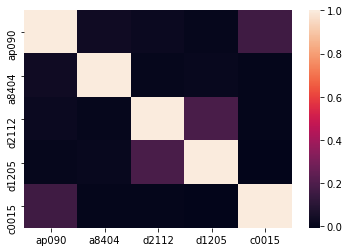

In [55]:
sns.heatmap(df_model.corr())

## Linear Regression Model with SKLEARN

### X and y arrays

In [56]:
from sklearn.model_selection import train_test_split

X = df_model.drop(labels=["ap090"],axis=1)
y = df_model['ap090']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25)

In [57]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
model=lm.fit(X,y)

## Model Evaluation

Let's evaluate the model by checking out it's coefficients and how we can interpret them.

In [58]:
# print the intercept
print("Constant: ", model.intercept_)
print("R2: ", model.score(X,y))

Constant:  -0.0507791972723891
R2:  0.026615118276756444


In [59]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
a8404,0.048605
d2112,0.011783
d1205,0.005341
c0015,0.069692


## Predictions from our Model

Let's grab predictions off our test set and see how well it did!

In [60]:
predictions = lm.predict(X)

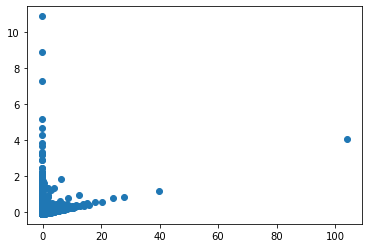

In [61]:
plt.scatter(y,predictions)

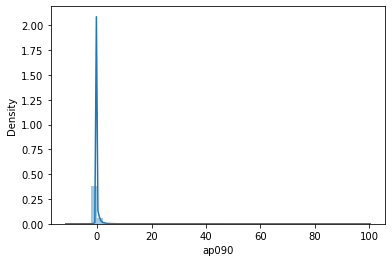

In [62]:
sns.distplot((y-predictions),bins=50);

In [63]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y, predictions))
print('MSE:', metrics.mean_squared_error(y, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, predictions)))

MAE: 0.34513200327945226
MSE: 0.9733848817232439
RMSE: 0.9866026969977549


In [64]:
X = sm.add_constant(X)

result = sm.OLS( y, X).fit()
print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                  ap090   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     205.0
Date:                Wed, 19 Jan 2022   Prob (F-statistic):          7.95e-174
Time:                        12:07:54   Log-Likelihood:                -42164.
No. Observations:               30000   AIC:                         8.434e+04
Df Residuals:                   29995   BIC:                         8.438e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0508      0.007     -7.480      0.0

### Conclusion - Linear Regression Model

This model it's not good enough to predict our main target because the metric R2 it's to low, so the prediction made by our model it's really poor. We can even take any insight due to the rebustless model we have. We are going to try to adjust our data to a Logistic Regression Model.

## Classification Model - Logistic Regression

Now the approach is totally different. We want to run our data through a classification model. We are going to set as our target variable ***ct090***. This is a binomial variable, and we have 1 set _True_ as a success of our 90 days outcome, and 0 sets as _False_. We are going to separate the features in categorical and numerical to perform some encoding to the categorical in order to let our model understand the categories and see the relevance of them, and for our numerical values, we will perform the same transformation we did on the Linear Regression model: Standard Scaling. 

In [65]:
df_data.head()

,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
case_id,,,,,,,,,,,,,,,,,,
1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.000000,238.38,2.0,0.00,98.0,0.0,49.0,0.0,1,1.0,222.69
2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,2.0,210.530000,0.00,5.0,0.00,109.0,2.0,51.0,0.0,2,1.0,212.72
3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,423.156043,0.00,2.0,0.00,748.0,0.0,48.0,0.0,3,1.0,56.84
4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,1.0,423.156043,54.14,3.0,1.00,8.0,0.0,27.0,0.0,4,1.0,463.15
5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.000000,83.00,6.0,0.36,324.0,0.0,40.0,0.0,1,1.0,146.09


In [66]:
df_data.dtypes

keydate     object
ct090      float64
ap090      float64
c0001      float64
c0039       object
c0044       object
d0031      float64
b0007      float64
d0009      float64
c0031      float64
a8404      float64
c0019      float64
d0027      float64
c9008      float64
d2112      float64
d0012       object
d1205      float64
c0015      float64
dtype: object

In [67]:
df_data.columns

Index(['keydate', 'ct090', 'ap090', 'c0001', 'c0039', 'c0044', 'd0031',
       'b0007', 'd0009', 'c0031', 'a8404', 'c0019', 'd0027', 'c9008', 'd2112',
       'd0012', 'd1205', 'c0015'],
      dtype='object')

In [68]:
df_data['c0039'].value_counts()

K6512    17329
K6622     9916
K6619     1391
K6419      909
K6499      410
K6491       24
K6420       15
K6511        6
Name: c0039, dtype: int64

In [69]:
categorical_values = ['c0039']
numerical_values = ['c0001', 'd0031','b0007', 'd0009', 'c0031','a8404', 
                    'c0019', 'd0027', 'c9008', 'd2112','d1205', 'c0015']
target = ['ct090']

In [70]:
df_model_class = pd.concat([df_data[target], df_data[categorical_values], df_data[numerical_values]], axis=1)

In [71]:
df_model_class.head()

,ct090,c0039,c0001,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
case_id,,,,,,,,,,,,,,
1,0.0,K6622,221.68,2.0,0.000000,238.38,2.0,0.00,98.0,0.0,49.0,0.0,1.0,222.69
2,0.0,K6512,151.36,2.0,210.530000,0.00,5.0,0.00,109.0,2.0,51.0,0.0,1.0,212.72
3,0.0,K6512,48.84,1.0,423.156043,0.00,2.0,0.00,748.0,0.0,48.0,0.0,1.0,56.84
4,0.0,K6622,413.15,1.0,423.156043,54.14,3.0,1.00,8.0,0.0,27.0,0.0,1.0,463.15
5,0.0,K6512,125.83,2.0,20.000000,83.00,6.0,0.36,324.0,0.0,40.0,0.0,1.0,146.09


In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_model_class[numerical_values] = scaler.fit_transform(df_model_class[numerical_values])
df_model_class[numerical_values]

,c0001,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
case_id,,,,,,,,,,,,
1,-0.253936,0.272246,-7.105373e-01,-0.163276,-0.508093,-0.912932,-0.035298,-0.338613,0.531094,-0.527438,0.111787,-0.312843
2,-0.310283,0.272246,-3.570284e-01,-0.286181,0.886617,-0.912932,0.020579,1.092953,0.690568,-0.527438,0.111787,-0.320990
3,-0.392431,-0.480507,9.544793e-17,-0.286181,-0.508093,-0.912932,3.266516,-0.338613,0.451356,-0.527438,0.111787,-0.448367
4,-0.100514,-0.480507,9.544793e-17,-0.258267,-0.043190,2.310553,-0.492472,-0.338613,-1.223129,-0.527438,0.111787,-0.116350
5,-0.330740,0.272246,-6.769545e-01,-0.243388,1.351520,0.247523,1.112717,-0.338613,-0.186543,-0.527438,0.111787,-0.375436
...,...,...,...,...,...,...,...,...,...,...,...,...
29996,-0.082637,0.272246,9.327005e-01,-0.161379,-0.043190,2.310553,-0.512791,-0.338613,-0.186543,1.148741,0.111787,-0.138977
29997,-0.155867,0.272246,9.544793e-17,12.814110,-0.508093,-0.042591,0.030738,0.377170,-0.186543,-0.527438,0.111787,-0.190442
29998,-0.097245,-0.480507,9.544793e-17,-0.286181,-0.043190,-0.622818,-0.009900,-0.338613,-0.106805,-0.527438,0.111787,-0.072796


In [73]:
df_model_class = pd.get_dummies(df_model_class, columns = categorical_values, drop_first=True)
df_model_class.head()

,ct090,c0001,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015,c0039_K6420,c0039_K6491,c0039_K6499,c0039_K6511,c0039_K6512,c0039_K6619,c0039_K6622
case_id,,,,,,,,,,,,,,,,,,,,
1,0.0,-0.253936,0.272246,-7.105373e-01,-0.163276,-0.508093,-0.912932,-0.035298,-0.338613,0.531094,-0.527438,0.111787,-0.312843,0,0,0,0,0,0,1
2,0.0,-0.310283,0.272246,-3.570284e-01,-0.286181,0.886617,-0.912932,0.020579,1.092953,0.690568,-0.527438,0.111787,-0.320990,0,0,0,0,1,0,0
3,0.0,-0.392431,-0.480507,9.544793e-17,-0.286181,-0.508093,-0.912932,3.266516,-0.338613,0.451356,-0.527438,0.111787,-0.448367,0,0,0,0,1,0,0
4,0.0,-0.100514,-0.480507,9.544793e-17,-0.258267,-0.043190,2.310553,-0.492472,-0.338613,-1.223129,-0.527438,0.111787,-0.116350,0,0,0,0,0,0,1
5,0.0,-0.330740,0.272246,-6.769545e-01,-0.243388,1.351520,0.247523,1.112717,-0.338613,-0.186543,-0.527438,0.111787,-0.375436,0,0,0,0,1,0,0


In [74]:
df_model_class.columns

Index(['ct090', 'c0001', 'd0031', 'b0007', 'd0009', 'c0031', 'a8404', 'c0019',
       'd0027', 'c9008', 'd2112', 'd1205', 'c0015', 'c0039_K6420',
       'c0039_K6491', 'c0039_K6499', 'c0039_K6511', 'c0039_K6512',
       'c0039_K6619', 'c0039_K6622'],
      dtype='object')

<AxesSubplot:>

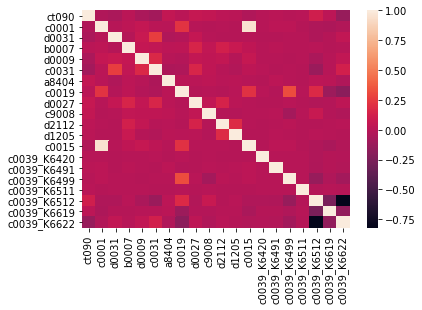

In [75]:
sns.heatmap(df_model_class.corr())

We can detect on the heatmap, some features with high correlation and we want to avoid multicollinearity because if not, our model will be less precise. 

In [76]:
df_model_class = df_model_class.drop(labels=["c0001",'c0039_K6491','c0039_K6511', 'c0039_K6512'], axis=1)

## Runing the Logistic Regression Model

The following steps of the code are the modeling part. First, we need to perform the train-test split model, in order to split our data for training (75%) and other for testing (25%). 

Once that is done, we are going to run the Logistic Regression Model only for our Train set of features. 

In [77]:
X = df_model_class.drop("ct090", axis = 1)
variables = X.columns
X = X.values

y = df_model_class["ct090"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25, stratify=y)

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

In [79]:
clf.score(X_train, y_train) # Score of our model

0.8312444444444445

In [80]:
clf.classes_ # Binomial classification (we already knew it because of the boolean value we had)

array([0., 1.])

In [81]:
clf.intercept_ # Value of our constant variable in the model

array([-1.421135])

In [82]:
clf.coef_ # Coeficients of each feature

array([[-0.05397614,  0.00593369, -0.20572494, -0.22737726,  0.08801726,
        -0.0260501 ,  0.20626387,  0.13507559,  0.01828569,  0.03136142,
        -0.09377783, -0.1890355 ,  0.0499923 , -0.01962684, -0.83256676]])

Feature: 0, Score: -0.34147
Feature: 1, Score: -0.05347
Feature: 2, Score: 0.00684
Feature: 3, Score: -0.20579
Feature: 4, Score: -0.23093
Feature: 5, Score: 0.08826
Feature: 6, Score: -0.01186
Feature: 7, Score: 0.20641
Feature: 8, Score: 0.13583
Feature: 9, Score: 0.01791
Feature: 10, Score: 0.03180
Feature: 11, Score: 0.19703
Feature: 12, Score: -0.29710
Feature: 13, Score: 0.50818
Feature: 14, Score: -0.12090
Feature: 15, Score: -0.57402
Feature: 16, Score: -0.16687
Feature: 17, Score: -0.15631
Feature: 18, Score: -0.98134


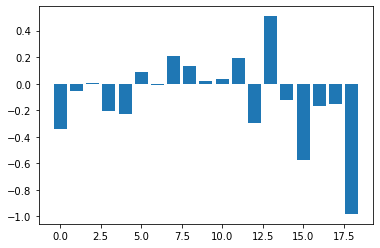

In [642]:
importance = clf.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0

In [83]:
clf.predict_proba(X_test) # Predicted Probabilities for our test set

array([[0.64535861, 0.35464139],
       [0.89562724, 0.10437276],
       [0.81592333, 0.18407667],
       ...,
       [0.74767672, 0.25232328],
       [0.74151685, 0.25848315],
       [0.90188655, 0.09811345]])

Probability for our test set. The left value of each interval is the probability to obtain the prediction point of our y_pred (next line of code) and the right part of the interval is the probability of getting the other value. If we see the following line of code, we have a 64.535861% of probability of getting a 0 (won't get an outcome in 90 days) and 35.464139% of getting a 1 (we will get an outcome in 90 days)

In [84]:
y_pred  = clf.predict(X_test) # Predicted values
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

#### CONFUSION MATRIX

In [85]:
confusion_matrix(y_test, y_pred)

array([[6218,   17],
       [1260,    5]], dtype=int64)

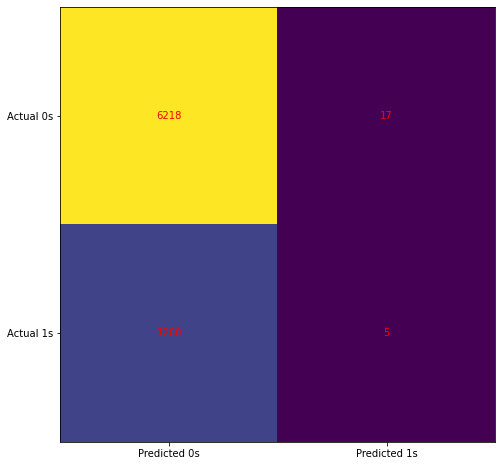

In [86]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

Here is where I want to make a clear explanation from the results we got. This matrix shows how well is performing our model in terms of predicting our target variable and how wrongly is performing as well. 

**GOOD PERFORMANCE OF OUR MODEL**
- On the left top corner we have the value called **True Negatives** and this means that our model is predicting that 6218 values are predicted like 0 and they really are 0. On the right bottom corner, we have the **True positives** meaning that 5 were predicted as 1 and they really are 1.

**BAD PERFORMANCE OF OUR MODEL**
- On the right top side of the matrix we have the **False Positives** meaning that 17 values were predicted as 1 but they really are 0. Finally, on the left bottom part, we have the **False Negatives** values, meaning that 1260 values were predicted as 0 and they really are 1. 

But these are the results for our calculation model withing within a threshold given to the model. We can see that there are many different thresholds for the same model, where you can modify the accuracy of our model and the results of our confusion matrix in our favor. And this can be done with the threshold value. So let's see the different results we can obtain for our model. 

***IMPORTANT***--> Sometimes the accuracy is not the most important metric of our model, sometimes we need to understand the whole meaning of our target variable in order to decide which solution is the best for us.

In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91      6235
         1.0       0.23      0.00      0.01      1265

    accuracy                           0.83      7500
   macro avg       0.53      0.50      0.46      7500
weighted avg       0.73      0.83      0.76      7500



### AUC ROC Curve Metric

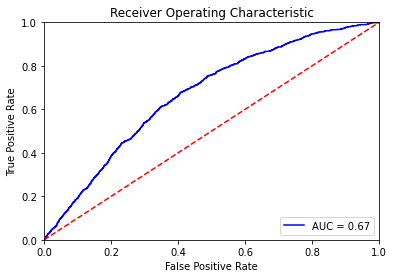

In [92]:
import sklearn.metrics as metrics

probs_y=clf.predict_proba(X_test)
preds = probs_y[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(0.0, 1.0)

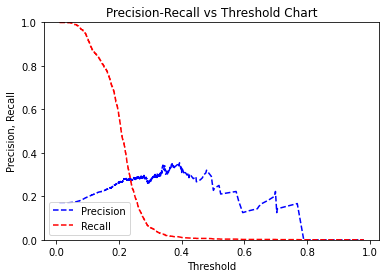

In [90]:
pred_y=clf.predict(X_test) 

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [88]:
pred_proba_df = pd.DataFrame(clf.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.05 ******
Our testing accuracy is 0.18946666666666667
[[ 161 6074]
 [   5 1260]]

******** For i = 0.1 ******
Our testing accuracy is 0.35213333333333335
[[1474 4761]
 [  98 1167]]

******** For i = 0.15 ******
Our testing accuracy is 0.5006666666666667
[[2739 3496]
 [ 249 1016]]

******** For i = 0.2 ******
Our testing accuracy is 0.6593333333333333
[[4225 2010]
 [ 545  720]]

******** For i = 0.25 ******
Our testing accuracy is 0.7785333333333333
[[5583  652]
 [1009  256]]

******** For i = 0.3 ******
Our testing accuracy is 0.8156
[[6045  190]
 [1193   72]]

******** For i = 0.35 ******
Our testing accuracy is 0.8270666666666666
[[6178   57]
 [1240   25]]

******** For i = 0.4 ******
Our testing accuracy is 0.8292
[[6206   29]
 [1252   13]]

******** For i = 0.45 ******
Our testing accuracy is 0.8296
[[6214   21]
 [1257    8]]

******** For i = 0.5 ******
Our testing accuracy is 0.8297333333333333
[[6218   17]
 [1260    5]]

******** For i = 0.55 ******
Our testi

So for us, the most convenient model will be for the highest threshold and the highest accuracy, but this is because of our target variable. For us, will be a good prediction even if our False Negatives are high because that would mean that we can wrongly predict they are 0 when they are real 1 values. So if we prepare our monthly economic planning for our directors applying our model in production to our data, we can say that we are going to predict 6235 values that are 0 and they would be real 0 values, and we will miss 1265 of False Negatives predicted as 0 when they really are 1. So we wouldn't lose money in terms of Amount of Outcome in 90 days. Understanding the target variable is the most important for any model and in this case, the best accuracy is the best model but for different datasets, could be the best threshold with less accuracy.

# FINAL STUDY FOR OUR MISSING NOT AT RANDOM MODEL

In [94]:
missing_data_pattern.head(3) # Dataset with a pattern on missing data

,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
case_id,,,,,,,,,,,,,,,,,,
3,2017-02-17 00:00:00.0,0.0,0.0,48.84,K6512,3,1.0,NaN,0.00,2.0,0.0,748.0,0.0,48.0,NaN,3,NaN,56.84
4,2017-09-18 00:00:00.0,0.0,0.0,413.15,K6622,4,NaN,NaN,54.14,3.0,1.0,8.0,0.0,27.0,NaN,4,NaN,463.15
6,2017-05-13 00:00:00.0,0.0,0.0,56.77,K6512,6,1.0,NaN,0.00,3.0,NaN,4.0,0.0,47.0,NaN,1,NaN,117.77


In [95]:
missing_data_no_pattern.head(3) # Dataset with no pattern on missing data

,keydate,ct090,ap090,c0001,c0039,c0044,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d0012,d1205,c0015
case_id,,,,,,,,,,,,,,,,,,
1,2017-08-12 00:00:00.0,0.0,0.0,221.68,K6622,1,2.0,0.00,238.38,2.0,NaN,98.0,0.0,49.0,0.0,1,NaN,222.69
2,2017-02-03 00:00:00.0,0.0,0.0,151.36,K6512,2,NaN,210.53,0.00,5.0,NaN,109.0,2.0,51.0,0.0,2,1.0,212.72
5,2017-07-22 00:00:00.0,0.0,0.0,125.83,K6512,5,2.0,20.00,83.00,6.0,NaN,324.0,0.0,40.0,0.0,1,NaN,146.09


We are going to perform the Logistic regression model to our Missing Data with the pattern because we want to check if we can find a model with better performance than the one we already studied. Let's see if the results are better or not. We need to take into account that we have reduced the amount of data when we have split the data into patterns. 

In [96]:
missing_data_pattern.isnull().sum()

keydate        0
ct090          0
ap090          0
c0001         16
c0039          0
c0044          0
d0031       6266
b0007      16926
d0009          0
c0031          0
a8404       5339
c0019          0
d0027          0
c9008       1787
d2112      16952
d0012          0
d1205      16942
c0015          0
dtype: int64

In [97]:
# Filling the null values for every feature as we did at the very begining
# For the features full of nulls (b0007,d2112,d1205) we will drop the columns

missing_data_pattern["c0001"]=missing_data_pattern["c0001"].fillna(missing_data_pattern["c0001"].mean())
missing_data_pattern["d0031"]=missing_data_pattern["d0031"].fillna(method='ffill', inplace=False)
missing_data_pattern["a8404"]=missing_data_pattern["a8404"].fillna(method='backfill', inplace=False)
missing_data_pattern["c9008"]=missing_data_pattern["c9008"].fillna(missing_data_pattern["c9008"].mean())
missing_data_pattern = missing_data_pattern.drop(labels=["b0007","d2112","d1205"], axis=1)

In [98]:
missing_data_pattern.isnull().sum()

keydate    0
ct090      0
ap090      0
c0001      0
c0039      0
c0044      0
d0031      0
d0009      0
c0031      0
a8404      0
c0019      0
d0027      0
c9008      0
d0012      0
c0015      0
dtype: int64

In [99]:
cat_values = ['c0039']
num_values = ['c0001', 'd0031', 'd0009', 'c0031','a8404', 
                    'c0019', 'd0027', 'c9008','c0015']
target = ['ct090']

In [100]:
missing_data_model = pd.concat([missing_data_pattern[target], missing_data_pattern[cat_values], missing_data_pattern[num_values]], axis=1)

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

missing_data_model[num_values] = scaler.fit_transform(missing_data_model[num_values])
missing_data_model[num_values]

,c0001,d0031,d0009,c0031,a8404,c0019,d0027,c9008,c0015
case_id,,,,,,,,,
3,-0.396026,-0.416052,-0.319635,-0.446805,-0.890669,3.289776,-0.274680,0.535075,-0.437633
4,-0.102727,-0.416052,-0.290460,0.078018,2.432077,-0.494174,-0.274680,-1.178307,-0.115985
6,-0.389641,-0.416052,-0.319635,0.078018,0.305519,-0.514627,-0.274680,0.453485,-0.389399
7,0.102166,-0.416052,-0.240371,0.602840,0.305519,-0.468606,-0.274680,-0.525590,0.085485
8,-0.373194,0.459978,-0.237423,-0.971628,0.305519,-0.207821,-0.274680,0.453485,-0.397276
...,...,...,...,...,...,...,...,...,...
29989,-0.257351,-1.292082,-0.319635,0.078018,0.205837,0.124553,-0.274680,1.514150,-0.291403
29990,-0.067851,-1.292082,-0.319635,1.127663,0.205837,-0.202707,-0.274680,-0.933538,-0.109399
29995,-0.193492,0.459978,-0.319635,0.078018,0.006472,-0.202707,-0.274680,0.000000,-0.232941


In [102]:
missing_data_model = pd.get_dummies(missing_data_model, columns = cat_values, drop_first=True)
missing_data_model.head()

,ct090,c0001,d0031,d0009,c0031,a8404,c0019,d0027,c9008,c0015,c0039_K6420,c0039_K6491,c0039_K6499,c0039_K6511,c0039_K6512,c0039_K6619,c0039_K6622
case_id,,,,,,,,,,,,,,,,,
3,0.0,-0.396026,-0.416052,-0.319635,-0.446805,-0.890669,3.289776,-0.27468,0.535075,-0.437633,0,0,0,0,1,0,0
4,0.0,-0.102727,-0.416052,-0.290460,0.078018,2.432077,-0.494174,-0.27468,-1.178307,-0.115985,0,0,0,0,0,0,1
6,0.0,-0.389641,-0.416052,-0.319635,0.078018,0.305519,-0.514627,-0.27468,0.453485,-0.389399,0,0,0,0,1,0,0
7,0.0,0.102166,-0.416052,-0.240371,0.602840,0.305519,-0.468606,-0.27468,-0.525590,0.085485,0,0,0,0,0,0,1
8,0.0,-0.373194,0.459978,-0.237423,-0.971628,0.305519,-0.207821,-0.27468,0.453485,-0.397276,0,0,0,0,0,0,1


<AxesSubplot:>

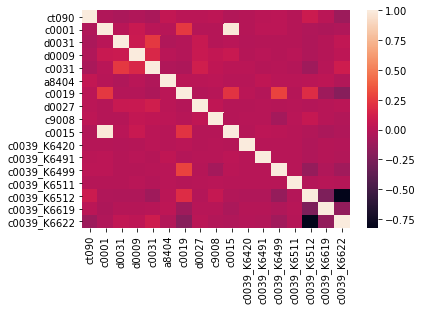

In [103]:
sns.heatmap(missing_data_model.corr())

In [104]:
# We still see some correlation between some variables, so we will drop them.

missing_data_model = missing_data_model.drop(labels=['c0001', 'c0039_K6491', 'c0039_K6511', 'c0039_K6512'], axis=1)

In [105]:
X = missing_data_model.drop("ct090", axis = 1)
variables = X.columns
X = X.values

y = missing_data_model["ct090"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.25, stratify=y)

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

clf = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

In [107]:
clf.score(X_train, y_train) # Score of our model

0.8868176812962089

THE MODEL SCORE IS MUCH MORE BETTER THAN THE ONE WE HAD FOR THE WHOLE MODEL

In [108]:
clf.intercept_ # Value of our constant variable in the model

array([-1.86234737])

In [109]:
clf.coef_ # Coeficients of each feature

array([[-0.13570412, -0.11317331, -0.16654325,  0.12530311, -0.04710681,
         0.04597607,  0.06599487, -0.12214652, -0.55370664,  0.38578691,
        -0.07180898, -0.88669281]])

Feature: 0, Score: -0.13570
Feature: 1, Score: -0.11317
Feature: 2, Score: -0.16654
Feature: 3, Score: 0.12530
Feature: 4, Score: -0.04711
Feature: 5, Score: 0.04598
Feature: 6, Score: 0.06599
Feature: 7, Score: -0.12215
Feature: 8, Score: -0.55371
Feature: 9, Score: 0.38579
Feature: 10, Score: -0.07181
Feature: 11, Score: -0.88669


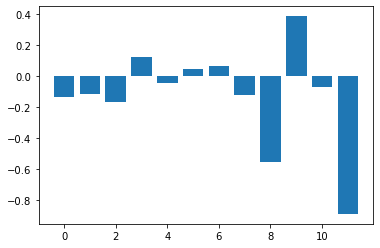

In [110]:
importance = clf.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Notice that the coefficients are both positive and negative. The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0

In [111]:
clf.predict_proba(X_test)

array([[0.84882329, 0.15117671],
       [0.9279679 , 0.0720321 ],
       [0.94275091, 0.05724909],
       ...,
       [0.89002167, 0.10997833],
       [0.87557326, 0.12442674],
       [0.8422497 , 0.1577503 ]])

Probability for our test set. The left value of each interval is the probability to obtain the prediction point of our y_pred (next line of code) and the right part of the interval is the probability of getting the other value. If we see the following line of code, we have a 64.535861% of probability of getting a 0 (won't get an outcome in 90 days) and 35.464139% of getting a 1 (we will get an outcome in 90 days)

In [112]:
y_pred  = clf.predict(X_test) # Predicted values
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

#### CONFUSION MATRIX

In [113]:
confusion_matrix(y_test, y_pred)

array([[3759,    0],
       [ 479,    0]], dtype=int64)

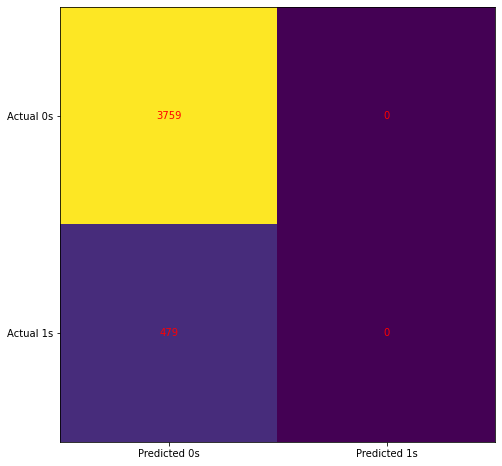

In [114]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      3759
         1.0       0.00      0.00      0.00       479

    accuracy                           0.89      4238
   macro avg       0.44      0.50      0.47      4238
weighted avg       0.79      0.89      0.83      4238



### AUC ROC Curve Metric

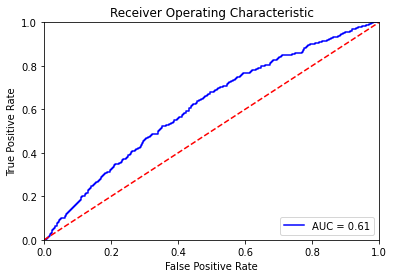

In [116]:
import sklearn.metrics as metrics

probs_y=clf.predict_proba(X_test)
preds = probs_y[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(0.0, 1.0)

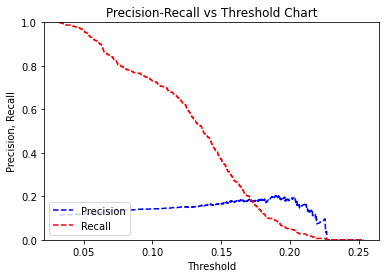

In [117]:
pred_y=clf.predict(X_test) 

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [118]:
pred_proba_df = pd.DataFrame(clf.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(y_test.to_numpy().reshape(y_test.to_numpy().size,1),
                           y_test_pred.iloc[:,1].to_numpy().reshape(y_test_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.05 ******
Our testing accuracy is 0.1828692779613025
[[ 315 3444]
 [  19  460]]

******** For i = 0.1 ******
Our testing accuracy is 0.4709768758848513
[[1646 2113]
 [ 129  350]]

******** For i = 0.15 ******
Our testing accuracy is 0.719443133553563
[[2871  888]
 [ 301  178]]

******** For i = 0.2 ******
Our testing accuracy is 0.8680981595092024
[[3656  103]
 [ 456   23]]

******** For i = 0.25 ******
Our testing accuracy is 0.8860311467673431
[[3755    4]
 [ 479    0]]

******** For i = 0.3 ******
Our testing accuracy is 0.8869749882019821
[[3759    0]
 [ 479    0]]

******** For i = 0.35 ******
Our testing accuracy is 0.8869749882019821
[[3759    0]
 [ 479    0]]

******** For i = 0.4 ******
Our testing accuracy is 0.8869749882019821
[[3759    0]
 [ 479    0]]

******** For i = 0.45 ******
Our testing accuracy is 0.8869749882019821
[[3759    0]
 [ 479    0]]

******** For i = 0.5 ******
Our testing accuracy is 0.8869749882019821
[[3759    0]
 [ 479    0]]

*****

### As a final conclusion for the whole study, performing 2 different types of models (linear and logistic regressions) and taking into consideration possible patterns on our missing data, we can say that the better prediction for our model is calculated for the first Logistic Regression model with less score than the one calculated for the pattern over the missing values. 

### Why? Because score/precision/accuracy is not always the best metric to understand the results. The AUC Curve says that the area score for the missing values pattern is 0.61 and the threshold is too low. Could be this because of the shortness of our dataset and this must be tested with more data. For the model without the missing pattern, we had an AUC curve score of 0.67 which is much better to understand our results. So if I would decide which model is better, I will say the first Logistic Regression model we have studied. 